# 推理与部署

[![下载Notebook](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/mindspore_infer.ipynb)&emsp;[![下载样例代码](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/mindspore_infer.py)&emsp;[![查看源文件](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/beginner/infer.ipynb)

本章使用MindSpore Vision中的`mobilenet_v2`网络微调的方法来开发一个AI应用（狗和牛角包分类），并将训练好的网络模型部署到Android手机上，执行推理和部署功能。

## 数据准备与加载

### 下载数据集

首先需要下载本案例所用到的[狗与牛角包分类数据集](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/beginner/DogCroissants.zip)，该数据集有狗和牛角包两个类别，每个类有大约150张训练图像、20张验证图像和1张推理图像。

具体数据集如下所示：

![datset-dog](https://gitee.com/mindspore/docs/raw/master/tutorials/source_zh_cn/beginner/images/datset_dog.png)

数据集的目录结构如下所示：

```text
datasets
└── DogCroissants
    ├── infer
    │   ├── croissants.jpg
    │   └── dog.jpg
    ├── train
    │   ├── croissants
    │   └── dog
    └── val
        ├── croissants
        └── dog
```

下载数据集的代码如下所示：

In [1]:
import os
import requests
import zipfile

requests.packages.urllib3.disable_warnings()

def download_dataset(url, target_path):
    """下载并解压数据集"""
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    download_file = url.split("/")[-1]

    if not os.path.exists(download_file):
        res = requests.get(url, stream=True, verify=False)

        if download_file.split(".")[-1] not in ["tgz", "zip", "tar", "gz"]:
            download_file = os.path.join(target_path, download_file)

        with open(download_file, "wb") as f:
            for chunk in res.iter_content(chunk_size=512):
                if chunk:
                    f.write(chunk)

    if download_file.endswith("zip"):
        z = zipfile.ZipFile(download_file, "r")
        z.extractall(path=target_path)
        z.close()

    print(f"{os.path.basename(url)} is downloaded and saved in path {target_path}")

dataset_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/beginner/DogCroissants.zip"
download_dataset(dataset_url, "./datasets")

DogCroissants.zip is downloaded and saved in path ./datasets


> 上述代码依赖第三方`requests`包，可使用命令`pip install requests`安装。

### 加载数据集

定义 `create_dataset`函数加载狗和牛角包数据集，对数据集进行图像增强操作并设置数据集batch_size大小。

In [2]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as transforms

def create_dataset(path, batch_size=10, train=True, image_size=224):
    dataset = ds.ImageFolderDataset(path, num_parallel_workers=8, class_indexing={"croissants": 0, "dog": 1})

    # 图像增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            transforms.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            transforms.RandomHorizontalFlip(prob=0.5),
            transforms.Normalize(mean=mean, std=std),
            transforms.HWC2CHW()
        ]
    else:
        trans = [
            transforms.Decode(),
            transforms.Resize(256),
            transforms.CenterCrop(image_size),
            transforms.Normalize(mean=mean, std=std),
            transforms.HWC2CHW()
        ]

    dataset = dataset.map(operations=trans, input_columns="image", num_parallel_workers=8)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

加载训练数据集和验证数据集用于后续的模型训练和验证。

In [3]:
# 加载训练数据集
train_path = "./datasets/DogCroissants/train"
dataset_train = create_dataset(train_path, train=True)

# 加载验证数据集
val_path = "./datasets/DogCroissants/val"
dataset_val = create_dataset(val_path, train=False)

## 模型训练

本案例使用预训练模型在[狗和牛角包的小数据集]((https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/beginner/DogCroissants.zip))上对模型进行微调，并将训练好的CKPT模型文件转换为MINDIR格式，用于后续手机侧的部署。

### MobileNet V2模型原理

MobileNet网络是由Google团队于2017年提出的专注于移动端、嵌入式或IoT设备的轻量级CNN网络，相比于传统的卷积神经网络，MobileNet网络使用深度可分离卷积（Depthwise Separable Convolution）的思想在准确率小幅度降低的前提下，大大减小了模型参数与运算量。并引入宽度系数 $\alpha$ 和分辨率系数 $\beta$ 使模型满足不同应用场景的需求。

由于MobileNet网络中Relu激活函数处理低维特征信息时会存在大量的丢失，所以MobileNetV2网络提出使用倒残差结构（Inverted residual block）和Linear Bottlenecks来设计网络，以提高模型的准确率，且优化后的模型更小。

![mobilenet](https://gitee.com/mindspore/docs/raw/master/tutorials/source_zh_cn/beginner/images/mobilenet.png)

图中Inverted residual block结构是先使用1x1卷积进行升维，然后使用3x3的DepthWise卷积，最后使用1x1的卷积进行降维。与Residual block结构相反，Residual block是先使用1x1的卷积进行降维，然后使用3x3的卷积，最后使用1x1的卷积进行升维。

> [详细内容可参见MobileNet V2论文](https://arxiv.org/pdf/1801.04381.pdf)

### 下载预训练模型

下载案例所需的[MobileNetV2预训练模型的ckpt文件](https://download.mindspore.cn/vision/classification/mobilenet_v2_1.0_224.ckpt)，预训练模型的宽度系数$\alpha= 1.0$，输入图像大小为(224, 224), 将下载的预训练模型保存在当前目录下。

In [4]:
import os

ckpt_path = "./mobilenet_v2_1.0_224.ckpt"
models_url = "https://download.mindspore.cn/vision/classification/mobilenet_v2_1.0_224.ckpt"

if not os.path.exists(ckpt_path):
    res = requests.get(models_url, stream=True, verify=False)

    with open(ckpt_path, "wb") as f:
        for chunk in res.iter_content(chunk_size=512):
            if chunk:
                f.write(chunk)
    print("Checkpoint download success.")
else:
    print("Checkpoint already exists.")

Checkpoint download success.


### MobileNet V2模型微调

本章使用MobileNet V2的预训练模型进行微调，通过删除MobileNet V2预训练模型中最后一个用于分类的1x1的卷积层的参数，使用狗与牛角包数据集对模型进行重新训练以更新模型参数。

In [ ]:
import mindspore.nn as nn
from mindspore.train import Model
from mindspore import load_checkpoint, load_param_into_net

from mindvision.classification.models import mobilenet_v2
from mindvision.engine.loss import CrossEntropySmooth

# 创建模型,其中目标分类数为2，图像输入大小为(224,224)
network = mobilenet_v2(num_classes=2, resize=224)

# 模型参数存入到param_dict
param_dict = load_checkpoint("./mobilenet_v2_1.0_224.ckpt")

# 获取mobilenet_v2网络最后一个卷积层的参数名
filter_list = [x.name for x in network.head.classifier.get_parameters()]

# 删除预训练模型的最后一个卷积层
def filter_ckpt_parameter(origin_dict, param_filter):
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break

filter_ckpt_parameter(param_dict, filter_list)

# 加载预训练模型参数作为网络初始化权重
load_param_into_net(network, param_dict)

# 定义优化器
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)

# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=0.1, classes_num=2)

# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}

# 初始化模型
model = Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

```text
Delete parameter from checkpoint:  head.classifier.weight
Delete parameter from checkpoint:  head.classifier.bias
Delete parameter from checkpoint:  moments.head.classifier.weight
Delete parameter from checkpoint:  moments.head.classifier.bias
```

### 模型训练与评估

训练并评估网络，使用MindSpore Vision中的`mindvision.engine.callback.ValAccMonitor`接口打印训练的损失值和评估精度，且在训练完成后，保存评估精度最高的CKPT文件`best.ckpt`在当前目录下。

In [ ]:
from mindvision.engine.callback import ValAccMonitor
from mindspore.train.callback import TimeMonitor

num_epochs = 10

# 模型训练与验证，训练完成后保存验证精度最高的ckpt文件（best.ckpt）到当前目录下
model.train(num_epochs,
            dataset_train,
            callbacks=[ValAccMonitor(model, dataset_val, num_epochs), TimeMonitor()])

```text
--------------------
Epoch: [  1 /  10],                   Train Loss: [0.047],                   Accuracy:  0.975.
epoch time: 63006.363 ms, per step time: 2172.633 ms
--------------------
Epoch: [  2 /  10],                   Train Loss: [0.015],                   Accuracy:  0.975.
epoch time: 58683.736 ms, per step time: 2023.577 ms
--------------------
Epoch: [  3 /  10],                   Train Loss: [0.092],                   Accuracy:  1.000.
epoch time: 58901.155 ms, per step time: 2031.074 ms
--------------------
Epoch: [  4 /  10],                   Train Loss: [0.081],                   Accuracy:  1.000.
epoch time: 60980.753 ms, per step time: 2102.785 ms
--------------------
Epoch: [  5 /  10],                   Train Loss: [0.009],                   Accuracy:  1.000.
epoch time: 58674.132 ms, per step time: 2023.246 ms
--------------------
Epoch: [  6 /  10],                   Train Loss: [0.110],                   Accuracy:  1.000.
epoch time: 59079.055 ms, per step time: 2037.209 ms
--------------------
Epoch: [  7 /  10],                   Train Loss: [0.014],                   Accuracy:  1.000.
epoch time: 59040.741 ms, per step time: 2035.888 ms
--------------------
Epoch: [  8 /  10],                   Train Loss: [0.087],                   Accuracy:  1.000.
epoch time: 58852.723 ms, per step time: 2029.404 ms
--------------------
Epoch: [  9 /  10],                   Train Loss: [0.013],                   Accuracy:  1.000.
epoch time: 60211.864 ms, per step time: 2076.271 ms
--------------------
Epoch: [ 10 /  10],                   Train Loss: [0.002],                   Accuracy:  1.000.
epoch time: 56891.139 ms, per step time: 1961.763 ms
================================================================================
End of validation the best Accuracy is:  1.000,               save the best ckpt file in ./best.ckpt
```

### 可视化模型预测

定义 `visualize_model` 函数，使用上述验证精度最高的模型对输入图像进行预测，并将预测结果可视化。

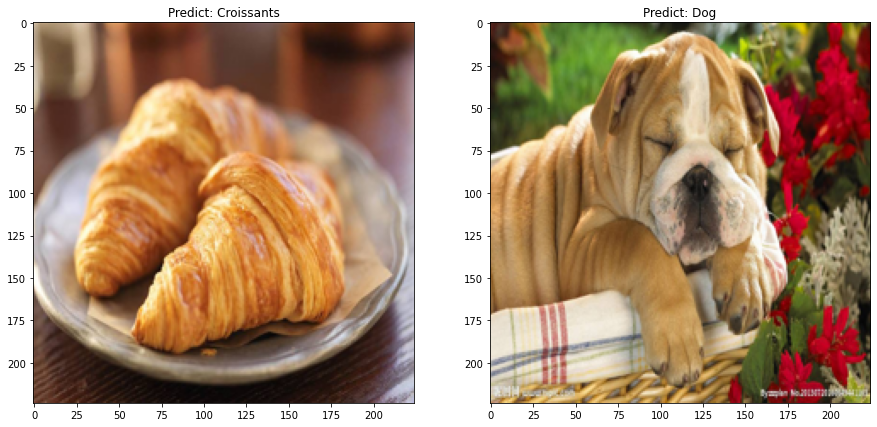

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from mindspore import Tensor

def visualize_model(path):
    image = Image.open(path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1，c, h, w)
    image = np.expand_dims(image, axis=0)

    # 定义并加载网络
    net = mobilenet_v2(num_classes=2, resize=224)
    param_dict = load_checkpoint("./best.ckpt")
    load_param_into_net(net, param_dict)
    model = Model(net)

    # 模型预测
    pre = model.predict(Tensor(image))
    result = np.argmax(pre)

    class_name = {0: "Croissants", 1: "Dog"}
    plt.title(f"Predict: {class_name[result]}")
    return result

image1 = "./datasets/DogCroissants/infer/croissants.jpg"
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
visualize_model(image1)

image2 = "./datasets/DogCroissants/infer/dog.jpg"
plt.subplot(1, 2, 2)
visualize_model(image2)

plt.show()

### 模型导出

在模型训练完后，训练完成后的网络模型（即CKPT文件）转换为MindIR格式，用于后续手机侧的推理。通过`export`接口会在当前目录下会生成`mobilenet_v2_1.0_224.mindir`文件。

In [8]:
from mindspore import export, Tensor

# 定义并加载网络参数
net = mobilenet_v2(num_classes=2, resize=224)
param_dict = load_checkpoint("best.ckpt")
load_param_into_net(net, param_dict)

# 将模型由ckpt格式导出为MINDIR格式
input_np = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
export(net, Tensor(input_np), file_name="mobilenet_v2_1.0_224", file_format="MINDIR")

## 手机侧推理与部署

为实现模型文件在手机侧的推理功能，步骤如下：

- 转换文件格式：将MindIR文件格式，转换成Android手机上MindSpore Lite可识别文件；
- 应用部署：在手机侧部署应用APK，即下载一个MindSpore Vision套件Android APK；
- 应用体验：最后将ms模型文件导入到手机侧后，体验狗与牛角包的识别功能。

### 转换文件格式

使用端侧应用的转换工具[MindSpore Lite Converter](https://www.mindspore.cn/lite/docs/zh-CN/master/use/converter_tool.html)，将训练过程当中生成的mobilenet_v2_1.0_224.mindir文件，转换为MindSpore Lite端侧推理框架可识别的文件格式mobilenet_v2_1.0_224.ms文件。

具体的模型文件格式转换方式如下所示：

1. Linux下使用MindSpore Lite Converter转换文件格式，[Linux-x86_64工具下载链接](https://www.mindspore.cn/lite/docs/zh-CN/master/use/downloads.html)。

```shell
# 设置软件包的路径，PACKAGE_ROOT_PATH为MindSpore Lite Converter工具包的路径
export PACKAGE_ROOT_PATH=./path

# 将转换工具需要的动态链接库加入到环境变量LD_LIBRARY_PATH
export LD_LIBRARY_PATH=${PACKAGE_ROOT_PATH}/tools/converter/lib:${LD_LIBRARY_PATH}

# 在mindspore-lite-linux-x64/tools/converter/converter执行转换命令
./converter_lite --fmk=MINDIR --modelFile=mobilenet_v2_1.0_224.mindir  --outputFile=custom
```

2. Windows下使用MindSpore Lite Converter转换文件格式，[Windows-x64工具下载链接](https://www.mindspore.cn/lite/docs/zh-CN/master/use/downloads.html)。

```shell
# 设置软件包的安装路径，path为MindSpore Lite Converter工具包的路径
set PACKAGE_ROOT_PATH=path

# 将转换工具需要的动态链接库加入到环境变量PATH
set PATH=%PACKAGE_ROOT_PATH%\tools\converter\lib;%PATH%

# 在mindspore-lite-win-x64\tools\converter\converter路径下执行转换命令
call converter_lite --fmk=MINDIR --modelFile=mobilenet_v2_1.0_224.mindir --outputFile=custom
```

转换成功后打印`CONVERT RESULT SUCCESS:0`，且在当前目录下生成`mobilenet_v2_1.0_224.ms`文件。

> 其他环境下载MindSpore Lite Converter参见[下载MindSpore Lite-推理](https://www.mindspore.cn/lite/docs/zh-CN/master/use/downloads.html)。

### 应用部署

使用MindSpore Vision套件Release的[mindspore.vison.xxx.apk](https://gitee.com/mindspore/vision/releases/)下载Android端应用APK，并在手机上安装该APK，其应用名称显示为`MindSpore Vision`。

> MindSpore Vision APK主要是作为视觉开发工具的示例所用，提供拍照、选择图片等基础UI功能，并且提供分类、检测、人脸识别等AI应用DEMO。

打开APP后，在首页点击`分类`模块后，即可点击中间按钮进行拍照获取图片，或者点击上侧栏的图像按钮选择进行图片相册用于图像分类功能。

<div align=center>![main](https://gitee.com/mindspore/docs/raw/master/tutorials/source_zh_cn/beginner/images/app1.png)</div>

在默认情况下，MindSpore Vision`分类`模块内置了一个通用的AI网络模型对图像进行识别分类。

<div align=center>![result](https://gitee.com/mindspore/docs/raw/master/tutorials/source_zh_cn/beginner/images/app2.png)</div>

### 应用体验

最后将上述训练的自定义网络模型mobilenet_v2_1.0_224.ms部署到Android手机侧，体验狗与牛角包的识别功能。

#### 自定义模型标签文件

自定义模型部署需要按照如下格式定义网络模型需要用到的信息，即自定义标签文件，并在本地电脑端侧创建一个必须以`custom.json`命名的json格式标签文件。

```text
{
    "title": '狗和牛角包',
    "file": 'mobilenet_v2_1.0_224.ms',
    "label": ['牛角包', '狗']
}
```

Json标签文件中需包含`title`，`file`，`label`三个Key值字段，其含义如下：

- title ：自定义模块标题(狗和牛角包)；
- file ：上文转换好的模型文件名称；
- label ：自定义标签label的`数组`信息。

#### 标签与模型文件部署到手机

在`MindSpore Vision APK`的首页上长按`分类`按钮，可以进入自定义分类模式，并且选择需要部署的标签和模型文件。

为实现手机端狗与牛角包的识别功能，需将标签文件`custom.json`文件和模型文件`mobilenet_v2_1.0_224.ms`一起放置到手机上指定目录下。这里以`Android/data/Download/` 文件夹为例，首先把标签文件和模型文件同时放在上述手机地址，如图所示，点击自定义按钮，然后会弹出系统文件功能，点击左上角的打开文件，然后找到Json标签文件和模型文件存放的目录地址，并选择对应的Json文件。

<div align=center>![step](https://gitee.com/mindspore/docs/raw/master/tutorials/source_zh_cn/beginner/images/app3.png)</div>

标签与模型文件部署到手机后，即可点击中间按钮进行拍照获取图片，或者点击上侧栏的图像按钮选择图片相册用于图像，就可以进行狗与牛角包的分类识别。

<div align=center>![result1](https://gitee.com/mindspore/docs/raw/master/tutorials/source_zh_cn/beginner/images/app4.png)</div>

> 本章仅包含手机侧简单的部署过程，想要了解推理更多内容请参考[MindSpore Lite](https://www.mindspore.cn/lite/docs/zh-CN/master/index.html)。